<a href="https://colab.research.google.com/github/twanglom/Sphere-Cavity-Shape-Optimization/blob/main/egro_Sphere_cavity_ShapeOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Efficient Global Robust Optimization Framework**

*   **Sphere Cavity Acoustic Shape Optimization : Considering Geometric Uncertainty**




**Package Requirement**

In [ ]:
!pip install torch
!pip install gpytorch
!pip install pymoo
!pip install optuna
!pip install pyDOE
!pip install scikit-learn

**Initial Runing Path**

In [ ]:
%cd /content/drive/MyDrive/PhD/Sphere Cavity Shape Optimization

/content/drive/MyDrive/PhD/Sphere Cavity Shape Optimization


**Verified Runtime Type**

In [ ]:
import torch
if torch.cuda.is_available():
    print("CUDA is available. GPU details:")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Device Memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is not available. Running on CPU.


**Computational Model (Objective)**

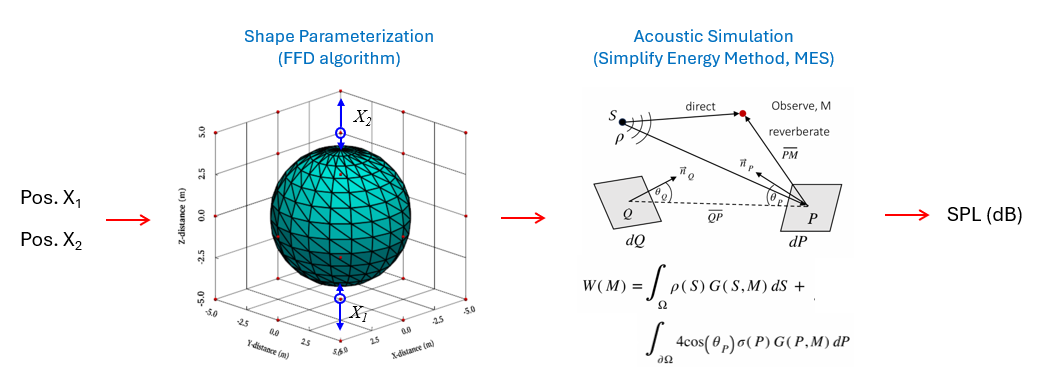

**Problem Formulation**

- Domain Information

| Description                     | Value                  |
| --------------------------------|------------------------|
| **Spherical radian**            | 4m                 |
| **Source power**                | 0.005 W            |
| **Source position**             | (0,0,0)             |  
| **Reveiver position**           | (0,0,-2)             |  
| **Absorption**                  | 0.3                 |
| **Mesh elements**               | 520                  |


---

- Input Information

| Description                     | Value                  |
| --------------------------------|------------------------|
| **Design Variable**             | $X_1$, $X_2$           |
| **Design Range**                | (0.5, -2), (-1.8, 2)   |
| **Number of Initial Samples**   | 40                     |
| - Training set                  | 30                     |
| - Validation set                | 10                     |


---

- Uncertainty Variable (Geomatry Uncertainty)

| Variable   | COV  | Distribution |
|------------|------|--------------|
| $X_1$ | 10%  | Normal       |
| $X_2$ | 10%  | Normal       |

---




**Design Shape Boundary**

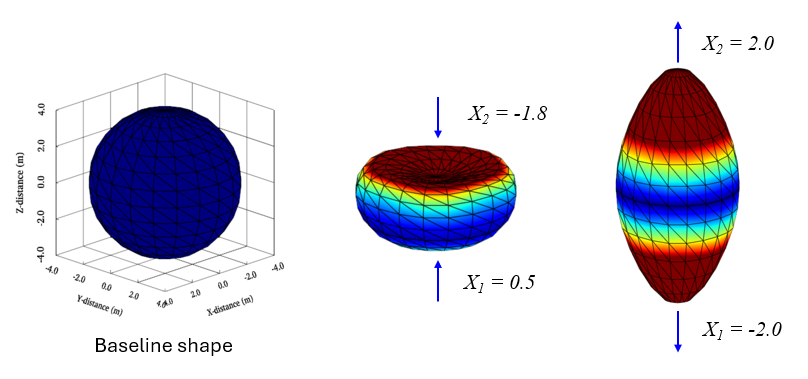

**STEP 1: Initial Design Sample and Evaluate Objective**

In [ ]:
!python step_0_initial_design.py

Training sample data saved to 'DATA_PREPARATION/training_data.csv'.
Testing sample data saved to 'DATA_PREPARATION/testing_data.csv'.
All information data saved to data_info.json.


**STEP 2: Constructing Stage 1 Gaussian Process Regression**
- This step will demonstrate the hyperparameter optimization, model traning and validaditon by testing data set
- all result file will be saved into log data as:

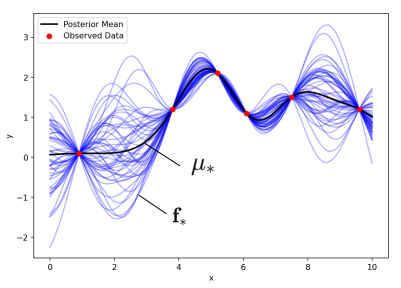







#### **GPR Model**


- **Prior Distribution (Before Observing Data)**


Given a set of training inputs $\{ x_1, x_2, \dots, x_n \}$, the function $f$ is modeled as:

$\hspace{3cm}$ $f = [f(x_1), f(x_2), \dots, f(x_n)]^T \sim \mathcal{N}(0, \mathbf{K})$

Where:
$\mathbf{K} $ is the covariance matrix generated using a kernel function $k(x, x')$

For example, with the Matérn 3/2 kernel:

$\hspace{4cm}$ $
k(x, x') = \sigma_f^2 \left( 1 + \frac{\sqrt{3} \lvert x - x' \rvert}{\ell} \right) \exp\left( -\frac{\sqrt{3} \lvert x - x' \rvert}{\ell} \right)
$

- Covariance Matrix Between Training Points

$
\mathbf{K} = \begin{bmatrix}
k(x_1, x_1) + \sigma_y^2 & k(x_1, x_2) & \dots & k(x_1, x_n) \\
k(x_2, x_1) & k(x_2, x_2) + \sigma_y^2 & \dots & k(x_2, x_n) \\
\vdots & \vdots & \ddots & \vdots \\
k(x_n, x_1) & k(x_n, x_2) & \dots & k(x_n, x_n) + \sigma_y^2
\end{bmatrix}
$

- Where hyperparameter:

$\hspace{2cm}$ $\ell$ is the length scale

$\hspace{2cm}$ $\sigma_f^2$ is the variance of the kernel (output scale)

$\hspace{2cm}$ $\sigma_y$ is the noise signal

- *We are going to sample* $f_*$ at $x_*$ *given the observed data* $Y_{train}$.

---

- **Posterior Distribution (After Observing Data)**

Given training data $X_{train}$, $Y_{train}$ and test input $x_*$, the posterior distribution for $f_*$ is given by:

$\hspace{5cm}$ $f_* \mid X, y, X_* \sim \mathcal{N}(\mu_*, \Sigma_*)$

Where:
- Mean: $\mu_* = \mathbf{K}_* \mathbf{K}^{-1} Y_{train}$
- Covariance: $\Sigma_* = \mathbf{K}_{**} - \mathbf{K}_* \mathbf{K}^{-1} \mathbf{K}_*^T$

Where:
- $\mathbf{K}_*$is the matrix of covariance between test points and training points.
- $\mathbf{K}_{**}$ is the matrix of covariance between test points.




In [ ]:
# Run file without ego (recommend for large data set)
!python step_1_stage1_meta_training.py

Using Device: cpu
**********
Learned hyperparameters:
Lengthscale: 5.678196430206299
Outputscale (Variance): 2.348796844482422
Noise: 0.0001374158455291763
Training MSE: 4.2425459780874744e-05, Test MSE: 6.044753970490716e-06
Training R²: 0.9999439514930648, Testing R²: 0.9999926639649945


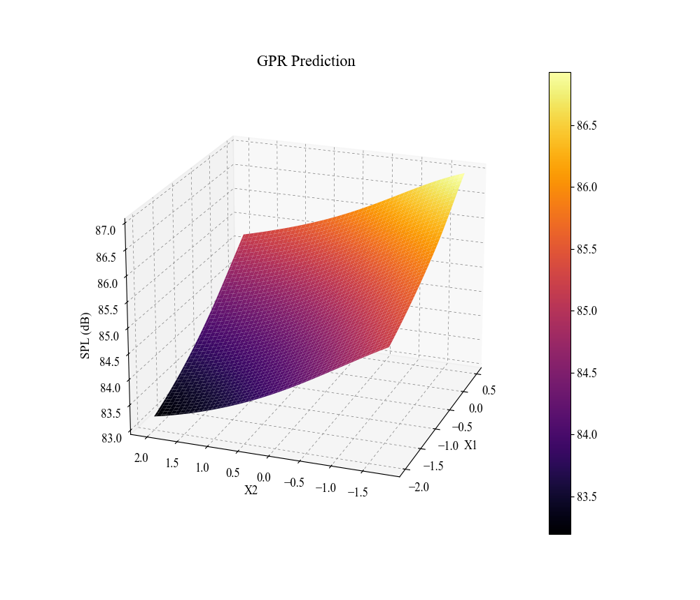

In [33]:
from PIL import Image
from IPython.display import display
img1 = Image.open('RESULT_R2_STAGE1_METAMODEL/GPR_response.png')
img1 = img1.resize((700, 600))
display(img1)

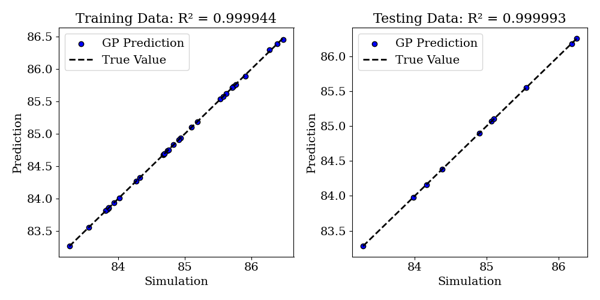

In [ ]:
from PIL import Image
from IPython.display import display
img1 = Image.open('RESULT_R2_STAGE1_METAMODEL/response_r2.png')
img1 = img1.resize((600, 300))
display(img1)

**STEP 3: Stochastic Simulator**


*   Load GPR model and the information of input range and distribution
*   Perform replication using Monte Carlo Simulation $10^6$ and $2500$ LHS samples
*   Estimate PDF, calculation μ and σ
*   Save all result in .csv file

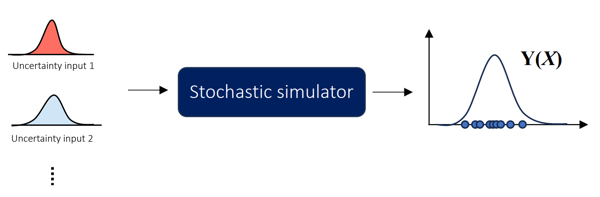



In [ ]:
!python step_2_uncertainty_propagating_mcs.py

**STEP 3: Constructing Stage 2 Multi-Layer Neural Network model**

*   This step will demonstrate the hyperparameter optimization, model traning and validaditon by testing data set

*   List item all result file will be saved into log data

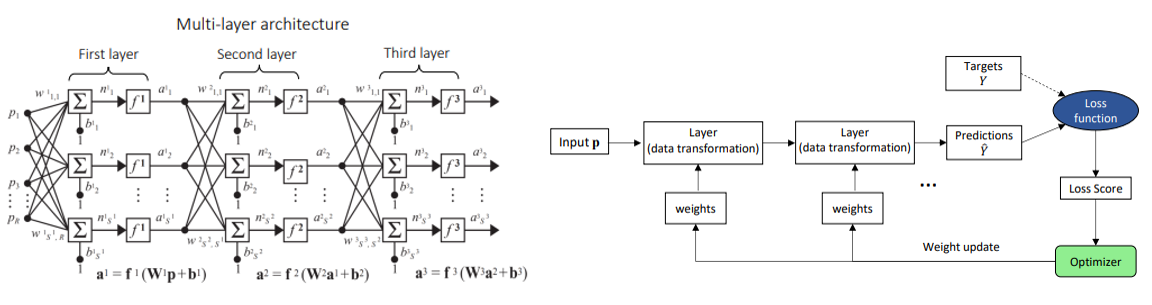


In [ ]:
!python step_3_stage2_meta_hyperparam.py

In [ ]:
!python step_3_stage2_meta_training.py

CUDA is not available. Running on CPU.
**********
Training the mean model...
**********
Training the std model...
**********
Mean Model Train R² Score: 1.0000
Mean Model Test R² Score: 1.0000
Std Model Train R² Score: 0.9997
Std Model Test R² Score: 0.9997


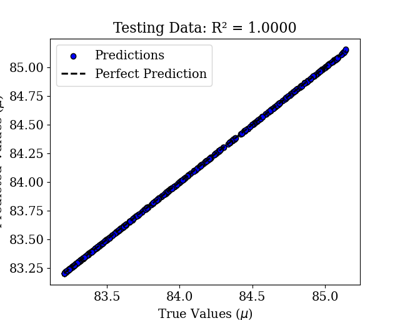

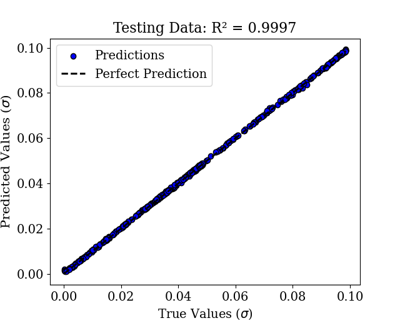

In [ ]:
from PIL import Image
from IPython.display import display
img1 = Image.open('RESULT_R2_STAGE2_METAMODEL/mean_test_r2.png')
img1 = img1.resize((400, 320))
display(img1)
img2 = Image.open('RESULT_R2_STAGE2_METAMODEL/std_test_r2.png')
img2 = img2.resize((400, 320))
display(img2)


**STEP 4: Multi-Objective Optimization**

*   Finding the best trade-off solution (pareto front) using NSGA-II
*   The optimized result will be saved to log file.


In [ ]:
!python step_4_multi_objective_optimization.py

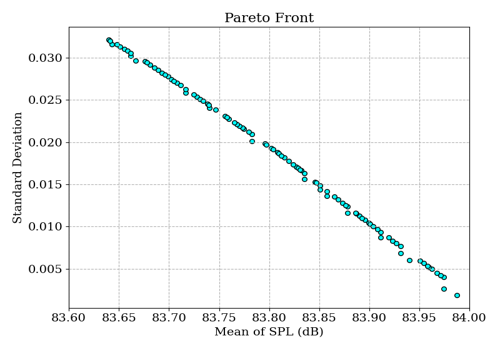

In [ ]:
from PIL import Image
from IPython.display import display
img1 = Image.open('RESULT_PARETO_FRONT/pareto_front.png')
img1 = img1.resize((500, 350))
display(img1)

## Pareto Front (Non-Dominate solution)

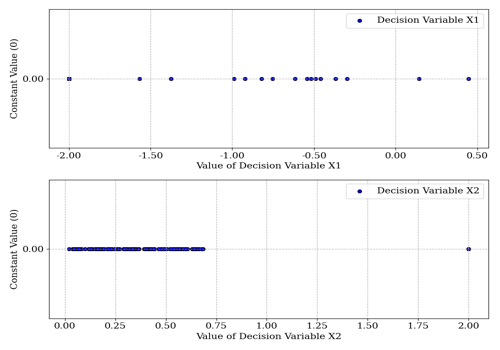

In [ ]:
from PIL import Image
from IPython.display import display
img2 = Image.open('RESULT_PARETO_FRONT/pareto_set.png')
img2 = img2.resize((500, 350))
display(img2)

## Decision solution

**Optimal Result**

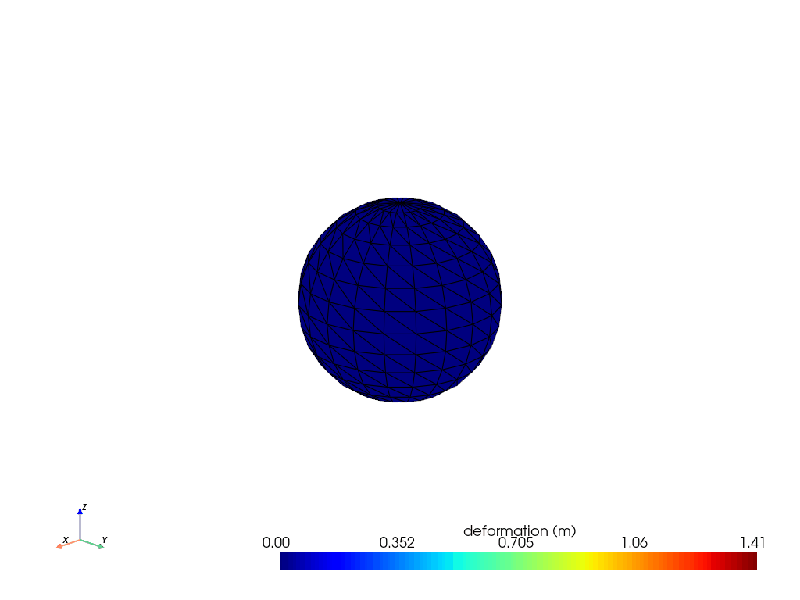

In [29]:
from PIL import Image
from IPython.display import display, Image as IPImage

gif_path = 'GEOMETRY/deformation_animation.gif'
gif = Image.open(gif_path)
new_size = (800, 600)
frames = []
try:
    while True:
        frame = gif.copy()
        frame = frame.resize(new_size, Image.LANCZOS)
        frames.append(frame)
        gif.seek(gif.tell() + 1)
except EOFError:
    pass

resized_gif_path = 'GEOMETRY/deformation_animation_resized.gif'
frames[0].save(resized_gif_path, save_all=True, append_images=frames[1:], loop=0, duration=gif.info['duration'])
display(IPImage(filename=resized_gif_path))
